## Introduction

**Objective:**

Generative Adversarial Networks (GAN) are neural networks capable of generating data. In fact, they can generate images so convincing that it is hard to believe they aren'treal. You can judge so for yourself by visiting https://thispersondoesnotexist.com, a website that shows faces generated by a GAN architecture called StyleGAN.

Our goal here will be to build a fine-tuned DL model to generate images of flags.

## Obtaining Image Dataset

[Flagpedia is our source](https://flagpedia.net/download/icons) for 254 flag images for training. I have put them in the directory `data/flags` in this repository.

In [ ]:
from skimage.io import imread_collection
#creating a collection of flag images
images = imread_collection('data/flags/*.png')

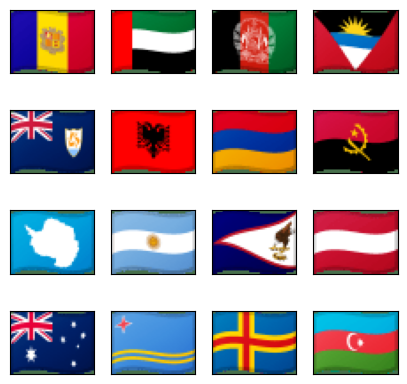

In [ ]:
import matplotlib.pyplot as plt

# make figure with the 16 images
plt.figure(figsize=(5,5))
for i in range(16):
    # position subplot in a 4x4 grid
    plt.subplot(4,4,i+1)

    # hide axes ticks and grid
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # show images
    plt.imshow(images[i])

# show the figure
plt.show()

## Neural Network Architecture

GANs are composed of two neural networks: a generator that tries to generate
data that looks similar to the training data, and a discriminator that tries to tell
real data from fake data.

Consider the generator as a student and the discriminator as the teacher. Let's build their brains (neural networks) now:

In [ ]:
import numpy as np
import tensorflow as tf

# set seed for psuedo random generator for reproducibility of results
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# import model and layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D, BatchNormalization, Conv2DTranspose

In [ ]:
def build_generator_upsample():
    '''
    Generator inspired by Nicholas Renotte's GAN for Fashion-MNIST:
    https://youtu.be/AALBGpLbj6Q?si=plfEWT08UpiG5iB0&t=3380
    '''
    model = Sequential()

    # Takes in 12 random values
    model.add(Dense(9*12*6, input_dim=6))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((9,12,6)))

    # Upsampling Conv block
    model.add(UpSampling2D())
    model.add(Conv2D(6, (3, 4), padding='same'))
    model.add(LeakyReLU(0.2))

    # Upsampling Conv block
    model.add(UpSampling2D())
    model.add(Conv2D(6, (3, 4), padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    model.add(Conv2D(3, (3, 4), padding='same', activation='sigmoid'))

    return model

def build_generator_conv2dtranspose():
    '''
    Generator inspired by TensorFlow documentation on DCGAN:
    https://www.tensorflow.org/tutorials/generative/dcgan
    '''
    model = Sequential()

    # Takes in 12 random values
    model.add(Dense(9*12*12, input_dim=6))
    model.add(LeakyReLU(0.2))
    model.add(Reshape((9,12,12)))

    # Conv2DTranspose block
    model.add(Conv2DTranspose(6, (3, 4), strides=(1,1), padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv2DTranspose block
    model.add(Conv2DTranspose(3, (3, 4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(0.2))

    # Conv layer to get to one channel
    model.add(Conv2DTranspose(3, (3, 4), strides=(2,2), padding='same', activation='sigmoid'))

    return model

# using upsampling generator as it gave better results; at least on the limited compute I used
generator = build_generator_upsample()
generator.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 648)               4536      
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 648)               0         
                                                                 
 reshape_2 (Reshape)         (None, 9, 12, 6)          0         
                                                                 
 up_sampling2d_2 (UpSamplin  (None, 18, 24, 6)         0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 18, 24, 6)         438       
                                                                 
 leaky_re_lu_9 (LeakyReLU)   (None, 18, 24, 6)         0         
                                                      

1/1 [==============================] - 0s 114ms/step


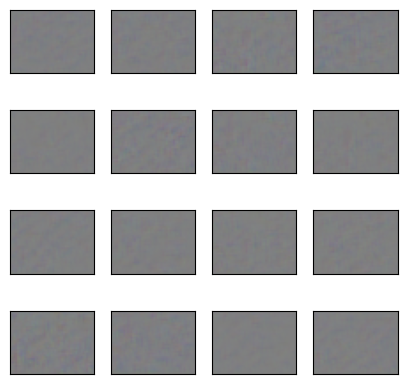

In [ ]:
# generate 16 images with untrained generator
gen_images = generator.predict(np.random.randn(16,6,1))

# make figure with the 16 images
plt.figure(figsize=(5,5))
for i in range(16):
    # position subplot in a 4x4 grid
    plt.subplot(4,4,i+1)

    # hide axes ticks and grid
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # show images
    plt.imshow(gen_images[i])

# show the figure
plt.show()

In [ ]:
def build_discriminator():
    '''
    Discriminator designed by myself through lot of experimentation.
    '''
    model = Sequential()

    # First Conv Block
    model.add(Conv2D(3, (3, 3), strides=(2, 2), padding='same', input_shape = (36,48,3)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Second Conv Block
    model.add(Conv2D(6, (3, 3), strides=(2, 2), padding='same'))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    # Flatten then pass to dense layer
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    return model

discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 18, 24, 3)         84        
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 18, 24, 3)         0         
                                                                 
 dropout_3 (Dropout)         (None, 18, 24, 3)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 9, 12, 6)          168       
                                                                 
 leaky_re_lu_12 (LeakyReLU)  (None, 9, 12, 6)          0         
                                                                 
 dropout_4 (Dropout)         (None, 9, 12, 6)          0         
                                                                 
 flatten_1 (Flatten)         (None, 648)              

In [ ]:
# determine real vs fake for the 16 images with an untrained discriminator
# this is just to verify that the discriminator has no errors
discriminator.predict(gen_images)

1/1 [==============================] - 0s 69ms/step


array([[0.55428255],
       [0.5535236 ],
       [0.5512289 ],
       [0.5525949 ],
       [0.55410117],
       [0.5538815 ],
       [0.551381  ],
       [0.5527389 ],
       [0.55085945],
       [0.55336386],
       [0.5536781 ],
       [0.55126673],
       [0.5539508 ],
       [0.55031985],
       [0.55271345],
       [0.5534783 ]], dtype=float32)

## Adversarial Training Setup

In [ ]:
# RMSprop is going to be the optimizer for both
# (Adam, the popular choice in GANs, is essentially RMSprop with momentum)
from tensorflow.keras.optimizers import RMSprop
# Binary cross entropy is going to be the loss for both
from tensorflow.keras.losses import BinaryCrossentropy
g_opt = RMSprop(learning_rate=0.0001)
d_opt = RMSprop(learning_rate=0.0001)
g_loss = BinaryCrossentropy()
d_loss = BinaryCrossentropy()

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf

class FlagGAN(Model):

    def __init__(self, generator, discriminator, *args, **kwargs):
        # Pass through args and kwargs to base class
        super().__init__(*args, **kwargs)

        # Create attributes for gen and disc
        self.generator = generator
        self.discriminator = discriminator

    def compile(self, g_opt, d_opt, g_loss, d_loss, *args, **kwargs):
        # Compile with base class
        super().compile(*args, **kwargs)

        # Create attributes for optimizers and losses
        self.g_opt = g_opt
        self.d_opt = d_opt
        self.g_loss = g_loss
        self.d_loss = d_loss

    def train_step(self, batch):
        '''
        Custom train_step for adversarial training
        Inspired by Nicholas Renotte's GAN for Fashion-MNIST:
        https://youtu.be/AALBGpLbj6Q?si=plfEWT08UpiG5iB0&t=4050
        '''
        
        # Get the data
        real_images = batch
        fake_images = self.generator(tf.random.normal((50, 6, 1)), training=False)

        # Train the discriminator
        with tf.GradientTape() as d_tape:
            # Pass the real and fake images to the discriminator model
            yhat_real = self.discriminator(real_images, training=True)
            yhat_fake = self.discriminator(fake_images, training=True)
            yhat_realfake = tf.concat([yhat_real, yhat_fake], axis=0)

            # Create labels for real and fakes images
            y_realfake = tf.concat([tf.zeros_like(yhat_real), tf.ones_like(yhat_fake)], axis=0)

            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(yhat_real))
            noise_fake = -0.15*tf.random.uniform(tf.shape(yhat_fake))
            y_realfake += tf.concat([noise_real, noise_fake], axis=0)

            # Calculate loss - BINARYCROSS
            total_d_loss = self.d_loss(y_realfake, yhat_realfake)

        # Apply backpropagation - nn learn
        dgrad = d_tape.gradient(total_d_loss, self.discriminator.trainable_variables)
        self.d_opt.apply_gradients(zip(dgrad, self.discriminator.trainable_variables))

        # Train the generator
        with tf.GradientTape() as g_tape:
            # Generate some new images batch of 50
            gen_images = self.generator(tf.random.normal((50,6,1)), training=True)

            # Create the predicted labels
            predicted_labels = self.discriminator(gen_images, training=False)

            # Calculate loss - trick to training to fake out the discriminator
            total_g_loss = self.g_loss(tf.zeros_like(predicted_labels), predicted_labels)

        # Apply backprop
        ggrad = g_tape.gradient(total_g_loss, self.generator.trainable_variables)
        self.g_opt.apply_gradients(zip(ggrad, self.generator.trainable_variables))

        return {"d_loss":total_d_loss, "g_loss":total_g_loss}

flag_GAN = FlagGAN(generator, discriminator)
flag_GAN.compile(g_opt, d_opt, g_loss, d_loss)

## Training and Testing

In [ ]:
# prepare dataset for training
ds = tf.data.Dataset.from_tensor_slices(images)
# scale images from 0 to 255 to 0 to 1
def scale_images(img):
    return img / 255
ds = ds.map(scale_images)
# make batches of 50 images
ds = ds.batch(50)

In [ ]:
# verify the dataset elements have dimensions as follows:
# (batch_size=50, height=36, width=48, color_channels=3)
list(ds.as_numpy_iterator())[0].shape

(50, 36, 48, 3)

In [ ]:
# adversarial training, showing the discriminator loss and generator loss
hist = flag_GAN.fit(ds, epochs=400)

Epoch 1/400
6/6 [==============================] - 2s 136ms/step - d_loss: 0.7514 - g_loss: 0.8008
Epoch 2/400
6/6 [==============================] - 1s 128ms/step - d_loss: 0.7655 - g_loss: 0.8081
Epoch 3/400
6/6 [==============================] - 1s 121ms/step - d_loss: 0.7256 - g_loss: 0.8133
Epoch 4/400
6/6 [==============================] - 1s 128ms/step - d_loss: 0.7416 - g_loss: 0.8208
Epoch 5/400
6/6 [==============================] - 1s 198ms/step - d_loss: 0.7133 - g_loss: 0.8267
Epoch 6/400
6/6 [==============================] - 1s 229ms/step - d_loss: 0.7183 - g_loss: 0.8287
Epoch 7/400
6/6 [==============================] - 1s 125ms/step - d_loss: 0.7282 - g_loss: 0.8296
Epoch 8/400
6/6 [==============================] - 1s 132ms/step - d_loss: 0.7075 - g_loss: 0.8328
Epoch 9/400
6/6 [==============================] - 1s 127ms/step - d_loss: 0.7298 - g_loss: 0.8336
Epoch 10/400
6/6 [==============================] - 1s 125ms/step - d_loss: 0.7096 - g_loss: 0.8314
Epoch 11/

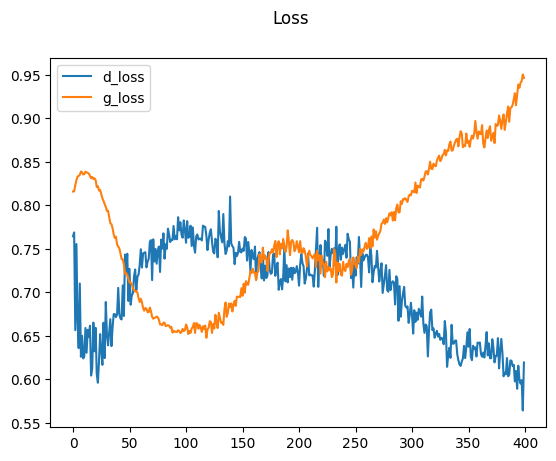

In [ ]:
plt.suptitle('Loss')
plt.plot(hist.history['d_loss'], label='d_loss')
plt.plot(hist.history['g_loss'], label='g_loss')
plt.legend()
plt.show()

Towards the end of training, the generator loss started spiking up while discriminator loss started going opposit way. In GANs training, this is a sign of mode collapse (refer Mode Collapse section at https://developers.google.com/machine-learning/gan/problems).

However, note that both losses are within 0.5 to 1.0 so the deviation is not too big.

Let's take a look at images generated by our trained generator:

1/1 [==============================] - 0s 50ms/step


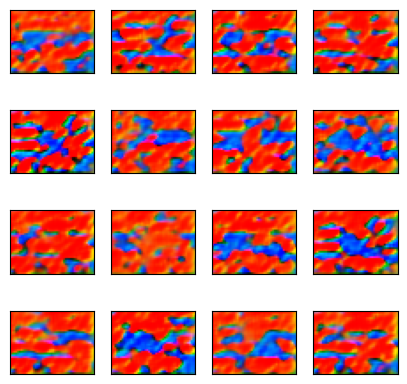

In [ ]:
# Finally, generate some images of flags
gen_images = generator.predict(np.random.randn(16,6,1))

# make figure with the 16 images
plt.figure(figsize=(5,5))
for i in range(16):
    # position subplot in a 4x4 grid
    plt.subplot(4,4,i+1)

    # hide axes ticks and grid
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)

    # show images
    plt.imshow(gen_images[i])

# show the figure
plt.show()

**Conclusion:**

The AI generated flag images look like a child's painting.

This is pretty much what we can expect given that we only had 254 flag images, i.e. a very tiny dataset, to train.

Despite that the results are quite beautiful and show some variations (creativity) across the flags.

**Future Work:**

Some ideas to improve:
- *Data Augmentation:* Although we only have 254 images of flag, we could increase dataset size by mirroring, shearing, recoloring, etc.
- *Early stopping:* We could get better results by saving the model at every 20% epoch progression in training. Then, we could use the model before divergence of losses.
- *Research on Generator Design:* More search into design of deep image generators can help create a better network architecture specialized in generating images.